## Simulation of Hofsadter Butterfly

In [1]:
import numpy as np
from math import comb
from tabulate import tabulate
import matplotlib.pyplot as plt
from itertools import combinations
import scipy.linalg as la

### parameters of the simulation

In [2]:
size=24
PBC=False
T_x=1
T_y=1
p=1
q=3
N=1 #nuner of particles
IPR_THRESHOLD=0.015

### Label double index to single one and viceversa (starting from bottom right to top left, filling every row from left to right)

In [3]:
def get_single_index_from_double(n,m, size=size): #n is column, m is row
    index=m*size+n
    return index

def get_double_index_from_single(index, size=size):
    n=index % size
    m=index//size 
    return n,m

### Get state from labels and viceversa

In [4]:
def get_state_from_label(state_number, size=size):
    state=np.zeros(size**2, dtype=bool)
    for i in range((size**2-1), -1, -1):
        if state_number >= (2**i):
            state[i] = True
            state_number=state_number - (2**i)
    return state


def get_label_from_state(state, size=size):
    state_number=0
    for i in range(size**2-1, -1, -1):
        if state[i]:
            state_number += 2**i
    return state_number

def get_double_index_state_from_label(state_number, size=size):
    state=get_state_from_label(state_number, size=size)
    double_index_state=np.zeros((size,size), dtype=bool)
    for i in range(size):
        for j in range(size):
            double_index_state[i,j]=state[get_single_index_from_double(i,j, size=size)]
    return double_index_state


def get_state_of_fixed_electron_number(i, N, size=size):
    """
    Finds the i-th integer (0-indexed) with exactly N set bits (ones).

    Args:
        i (int): The 0-based index of the desired number in the lexicographical order.
        N (int): The number of set bits (ones) the number must have.
        size (int): The grid size, determining the total number of bits (size*size).
    """
    total_bits = size**2

    if not (0 <= N <= total_bits and i >= 0):
        raise ValueError("N must be between 0 and total_bits, and index i must be non-negative.")

    # Check if the index is valid. The number of ways to choose N bits
    # from total_bits is the total number of valid states.
    total_combinations = comb(total_bits, N)
    if i >= total_combinations:
        raise ValueError(f"Index {i} is out of range. For N={N}, the max index is {total_combinations - 1}.")

    result = 0
    # Iterate from the most significant bit to the least
    for bit in range(total_bits - 1, -1, -1):
        if N == 0:
            break

        # If we must place a '1' here because the number of remaining bits
        # equals the number of ones we still need to place.
        if N == bit + 1:
            result |= (1 << (bit + 1)) - 1 # Set all remaining bits to 1
            break

        # Calculate the number of combinations that would have a '0' at this bit (talking about the bit corresponding to bit+1).
        # This is the number of ways to choose N ones from the remaining 'bit' positions.
        combinations_with_zero = comb(bit, N)

        if i < combinations_with_zero:
            # The i-th number is within the block of numbers that have a '0'
            # at this position. So we place a '0' (i.e., do nothing).
            pass
        else:
            # The i-th number is in the block that has a '1' at this position.
            result |= (1 << bit)  # Place a '1'
            i -= combinations_with_zero  # Subtract the combinations we skipped
            N -= 1  # One less '1' to place
    state = get_state_from_label(result, size=size)
    #print(f"Label: {get_label_from_state(state, size=size)}")
    return state



### compute hamiltonian components

#### $H=T(\sum_{<i,j>}e^{i\theta_{n,m}}c^{\dag}_{n^{\prime},m^{\prime}}c_{n,m}+h.c.)$ with $\theta_{m,n}=\frac{e}{\hbar}\int_{m,n}^{m\prime,n\prime}A\cdot dl$

#### define phase factor coefficients

In [5]:
def get_phases(q=q,p=p, size=size):
    if size%q != 0:
        raise ValueError("Size must be divisible by q") #condition can be relaxed when not using PBC, do in the future
    else:
        phases=np.zeros(q, dtype=complex)
        for i in range(q):
            phases[i] = np.exp(-2j * p * np.pi * i / q)
    return phases  
    

#### Helper functions

In [6]:
def reduce_array_for_periodicity(state, shift, q=q, size=size): #this takes the full array value and contracts by column, shift is the step in the periodicty to account for
    reduced_state=np.zeros((size//q,size), dtype=bool)
    for i in range(size//q):
        for j in range(size):
            reduced_state[i,j]= state[i*q+shift,j]
    return reduced_state

def check_if_occupied(n,m,state): ## check if the site (n,m) is occupied
    if state[get_single_index_from_double(n,m)] == True:
        return True
    else:
        return False
    
def calculate_IPR(vector): #Inverse Participation Ratio to filter out edge states in OBC
    vector = np.abs(vector) ** 2
    ipr = np.sum(vector ** 2)
    return ipr



#### Full Hamiltonain

In [7]:

    
def get_full_hamiltonian(size=size, PBC=PBC, T_y=T_y, T_x=T_x, p=p, q=q, progress_bar=False):
    H=np.zeros((2**(size**2), 2**(size**2)),dtype=complex)
    phases= get_phases(q, p,size=size)

    t=0
    for i in range(2**(size**2)):
        if progress_bar:    
            t=t+1
            print(f"Processing state {t}/{2**(size**2)}")     #uncomment for progress bar

        ket_state = get_state_from_label(i, size=size)
        #print("ket_state:", ket_state)
        ket_state_double = get_double_index_state_from_label(get_label_from_state(ket_state, size=size), size=size)

        for period_index in range(len(phases)):
            
            
            reduced_state = reduce_array_for_periodicity(ket_state_double, period_index, q)
            for k in ([-1,+1]): ##drop the minus one if the you want to add the conjugate
                bra_state = np.zeros(size**2, dtype=bool)
                #check=False      ##this is to avoid putting bra kets with all zeroes
                for index1 in range(size//q):
                    for index2 in range(size):
                        if reduced_state[index1,index2]==True:
                            check=True
                            n=index1*q+period_index
                            m=index2

                            bra_state = ket_state.copy() 
                            bra_state[get_single_index_from_double(n,m)]=False
                            if PBC:
                                m_k = (m + k) % size
                            else:
                                m_k = m + k
                                if m_k < 0 or m_k > size-1:
                                    continue
                            if check_if_occupied(n,m_k,ket_state): ##two fermionic creation operators give zero, this allow to exclude those cases
                                continue
                            bra_state[get_single_index_from_double(n,m_k)]=True
                        #if check:
                            H[get_label_from_state(ket_state), get_label_from_state(bra_state)] = -(phases[period_index])**(k) * T_y
                    # print("ket_state:", ket_state)
                    # print("bra_state:", bra_state)
            

        
        for k in ([-1,+1]):             
            for index in range(len(ket_state)):
                bra_state = np.zeros(size**2, dtype=bool)
                if ket_state[index]==True:   
                    (n,m)= get_double_index_from_single(index)  
                    bra_state = ket_state.copy() 
                    bra_state[get_single_index_from_double(n,m)]=False
                    if PBC:
                        n_k = (n + k) % size
                    else:
                        n_k = n + k
                        if n_k < 0 or n_k > size-1:
                            continue
                    if check_if_occupied(n_k,m,ket_state):
                        continue
                    bra_state[get_single_index_from_double(n_k, m)] = True
                    H[get_label_from_state(ket_state), get_label_from_state(bra_state)] = -T_x
    return H

#H=np.conjugate(H.T)+H# THIS IS HORRIBLY INEFFICENT, FUCK YOU NUMPY
# print("Hamiltonian H:", H)
# print("Hamiltonian H shape:", H.shape)

#### Hamiltonian per fixed number of particle

In [8]:
N=1  #electrons number
one_electron=False
if one_electron:
    N=1


def get_number_of_state_per_fixed_number(N, size=size):
    if one_electron:
        fixed_size=size**2
    else:
        fixed_size=comb(size**2 , N)

    return fixed_size

def find_index_of_state(state_list, target_state):
    #print(target_state)
    for temp, state in enumerate(state_list):
        if np.array_equal(state, target_state): 
            return temp
    return -1

In [9]:
def get_hamiltonian_for_fixed_number_of_electrons( N, PBC=PBC, T_y=T_y, T_x=T_x, p=p, q=q, progress_bar=False, size=size):
    fixed_size=get_number_of_state_per_fixed_number(N)
    state_list = [None] * fixed_size  # Initialize state_list with the appropriate size
    for i in range(fixed_size):
        state_list[i] = get_state_of_fixed_electron_number(i, N) ##crea inversa della funzione se vedi che questo è bottleneck

    
    H=np.zeros((fixed_size, fixed_size),dtype=complex)
    phases= get_phases(q, p,size=size)

    t=0
    for i in range(fixed_size):
        if progress_bar:    
            t=t+1
            print(f"Processing state {t}/{fixed_size}")     #uncomment for progress bar

        ket_state=state_list[i]
        #print("ket_state:", ket_state)
        ket_state_double = get_double_index_state_from_label(get_label_from_state(ket_state, size=size), size=size)

        for period_index in range(len(phases)):
            
            
            reduced_state = reduce_array_for_periodicity(ket_state_double, period_index, q)
            for k in ([-1,+1]): ##drop the minus one if the you want to add the conjugate
                bra_state = np.zeros(size**2, dtype=bool)
                #check=False      ##this is to avoid putting bra kets with all zeroes
                for index1 in range(size//q):
                    for index2 in range(size):
                        if reduced_state[index1,index2]==True:
                            check=True
                            n=index1*q+period_index
                            m=index2

                            bra_state = ket_state.copy() 
                            bra_state[get_single_index_from_double(n,m)]=False
                            if PBC:
                                m_k = (m + k) % size
                            else:
                                m_k = m + k
                                if m_k < 0 or m_k > size-1:
                                    continue
                            if check_if_occupied(n,m_k,ket_state): ##two fermionic creation operators give zero, this allow to exclude those cases
                                continue
                            bra_state[get_single_index_from_double(n,m_k)]=True
                        #if check:
                            H[find_index_of_state(state_list,bra_state),i] = -(phases[period_index])**(k) * T_y
                    # print("ket_state:", ket_state)
                    # print("bra_state:", bra_state)
            

        
        for k in ([-1,+1]):             
            for index in range(len(ket_state)):
                bra_state = np.zeros(size**2, dtype=bool)
                if ket_state[index]==True:   
                    (n,m)= get_double_index_from_single(index)  
                    bra_state = ket_state.copy() 
                    bra_state[get_single_index_from_double(n,m)]=False
                    if PBC:
                        n_k = (n + k) % size
                    else:
                        n_k = n + k
                        if n_k < 0 or n_k > size-1:
                            continue
                    if check_if_occupied(n_k,m,ket_state):
                        continue
                    bra_state[get_single_index_from_double(n_k, m)] = True
                    H[find_index_of_state(state_list,bra_state),i] = -T_x
    return H

H=get_hamiltonian_for_fixed_number_of_electrons(1, progress_bar=True)
print("Hamiltonian H shape:", H.shape)

print(tabulate(H, tablefmt="grid"))

Processing state 1/576
Processing state 2/576
Processing state 3/576
Processing state 4/576
Processing state 5/576
Processing state 6/576
Processing state 7/576
Processing state 8/576
Processing state 9/576
Processing state 10/576
Processing state 11/576
Processing state 12/576
Processing state 13/576
Processing state 14/576
Processing state 15/576
Processing state 16/576
Processing state 17/576
Processing state 18/576
Processing state 19/576
Processing state 20/576
Processing state 21/576
Processing state 22/576
Processing state 23/576
Processing state 24/576
Processing state 25/576
Processing state 26/576
Processing state 27/576
Processing state 28/576
Processing state 29/576
Processing state 30/576
Processing state 31/576
Processing state 32/576
Processing state 33/576
Processing state 34/576
Processing state 35/576
Processing state 36/576
Processing state 37/576
Processing state 38/576
Processing state 39/576
Processing state 40/576
Processing state 41/576
Processing state 42/576
P

/Users/massimodicosimo/miniconda3/envs/qc24/lib/python3.13/site-packages/tabulate/__init__.py:827: ComplexWarning: Casting complex values to real discards the imaginary part
  conv(string)
/Users/massimodicosimo/miniconda3/envs/qc24/lib/python3.13/site-packages/tabulate/__init__.py:1232: ComplexWarning: Casting complex values to real discards the imaginary part
  return format(float(val), floatfmt)


+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------+------+----+------

In [10]:
M=np.zeros((2,2), dtype=complex)
M[0,0]=1
print(M)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]


### Building Butterfly for fixed number of particles

In [11]:
def get_energy_bands_per_flux(N=N, size=size, PBC=PBC, T_y=T_y, T_x=T_x):
    energies = []
    fluxes = []
    ipr_eigenvectors = []
    for denominator in range(1, (size // 2) + 1):
        if size % denominator == 0:
            for numerator in range(0, denominator + 1):
                eigenvalues, eigenvectors = np.linalg.eigh(
                    get_hamiltonian_for_fixed_number_of_electrons(
                        N, PBC=PBC, T_y=T_y, T_x=T_x, p=numerator, q=denominator, progress_bar=False))
                energies.append(eigenvalues)
                fluxes.append(numerator / denominator)
                if PBC == False:
                    ipr_eigenvectors.append([calculate_IPR(eigenvectors[:, i]) for i in range(eigenvectors.shape[1])])
    return fluxes, np.array(energies), np.array(ipr_eigenvectors)


# Generate the Hofstadter butterfly with Aubry-Andrè model
def generate_hofstadter_butterfly(resolution=400, size=size, PBC=PBC, T_y=T_y, T_x=T_x):
    fluxes = np.linspace(0, 1, resolution)  # Flux values from 0 to 1
    k_y_values = np.linspace(0, 2 * np.pi, size, endpoint=False) #endpoint False beacuse 0 and 2pi are equal
    all_energies = []
    for alpha in fluxes:
        energies_for_alpha = []
        for k_y in k_y_values: #this is the conserved momentum in the y-direction. Usual butterfly is plotted with k_y=0, that why we see only (size) eigenvalues
            hamiltonian = np.zeros((size, size)) # Matrix is real, complex type not needed
            if PBC:
                for i in range(size):
                    # Hopping terms
                    hamiltonian[i, (i + 1) % size] = -T_x
                    hamiltonian[(i + 1) % size, i] = -T_x
                    # On-site potential
                    hamiltonian[i, i] = -(2*T_y) * np.cos(2 * np.pi * alpha * i +k_y)
            else:
                for i in range(size):
                    # Hopping terms for Open Boundary Conditions
                    if i < size - 1:
                        hamiltonian[i, i + 1] = -T_x
                        hamiltonian[i + 1, i] = -T_x
                        # On-site potential
                        hamiltonian[i, i] = -(2*T_y) * np.cos(2 * np.pi * alpha * i+k_y)


            eigvals = np.linalg.eigvalsh(hamiltonian)
            energies_for_alpha.extend(eigvals)
        
        all_energies.append(energies_for_alpha)
    return fluxes, np.array(all_energies)



In [12]:
fluxes_hof, energies_hof = generate_hofstadter_butterfly(resolution=500)
fluxes_mydata, energies_mydata, ipr_values = get_energy_bands_per_flux(N=N, size=size, PBC=PBC, T_y=T_y, T_x=T_x)


# flatten the energy array and create a corresponding flux value for each energy point.
flux_array_hof = np.repeat(fluxes_hof, energies_hof.shape[1])
energy_array_hof = energies_hof.flatten()


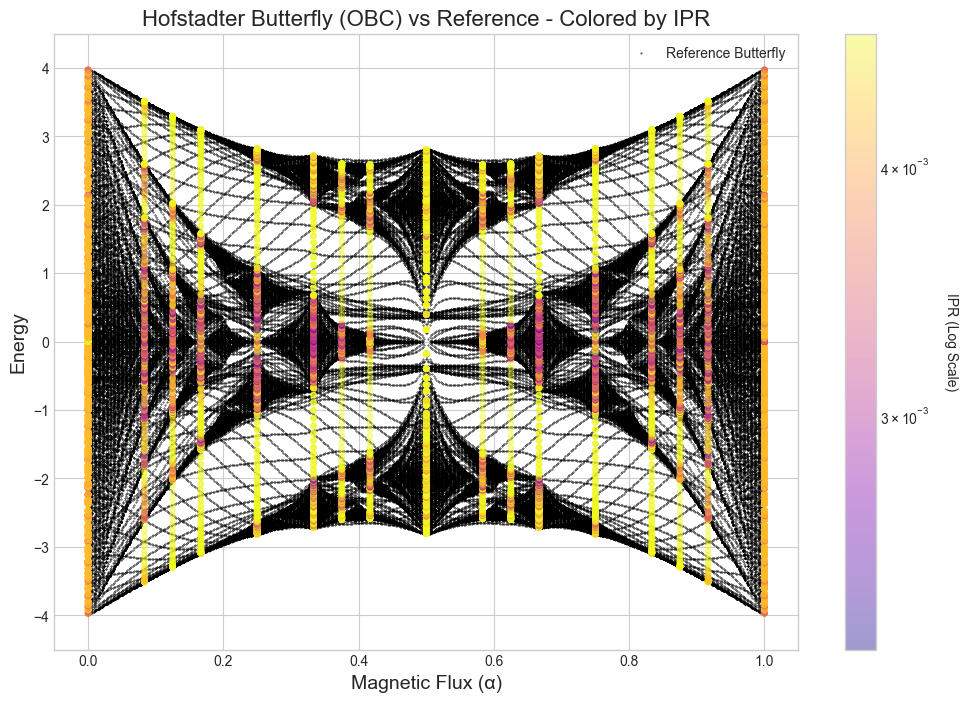

In [13]:

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors # Import for LogNorm


plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))


# This is plotted first, in black, as a fine-grained background.

plt.scatter(flux_array_hof, energy_array_hof, s=0.5, c='black', marker='.', label='Reference Butterfly')

# --- Plot 2: Your Calculated Data (Superimposed) ---
if PBC == True:
    flux_array_mydata = np.repeat(fluxes_mydata, energies_mydata.shape[1])
    energies_array_mydata = energies_mydata.flatten()
    
    plt.scatter(flux_array_mydata, energies_array_mydata, alpha=0.5, s=15, c='red', label='My Data (PBC)')
    plt.title("Hofstadter Butterfly (PBC) vs Reference", fontsize=16)

else: # This block handles the OBC case with IPR coloring
    #  Flatten the arrays to align each data point
    flux_array = np.repeat(fluxes_mydata, energies_mydata.shape[1])
    energy_array = energies_mydata.flatten()
    ipr_array = ipr_values.flatten()

    #  Use a logarithmic color scale for better visibility ---
    # add a small epsilon to vmin to avoid errors if the minimum IPR is zero.
    # gamma_val = 1.8
    # power_norm = mcolors.PowerNorm(gamma=gamma_val, vmin=ipr_array.min(), vmax=ipr_array.mean())
    log_norm = mcolors.LogNorm(vmin=ipr_array.min() + 1e-9, vmax=ipr_array.mean()-0)

    # Create the scatter plot with color mapped to IPR via the log scale
    scatter_plot = plt.scatter(
        flux_array,
        energy_array,
        c=ipr_array,      # Use the IPR array for color mapping
        cmap='plasma',   # A good colormap for this is 'viridis' or 'plasma'
        s=15,             # Make markers large enough to see
        alpha=0.4,
        norm=log_norm     # Apply the logarithmic normalization here
        #norm=power_norm  # Use PowerNorm for gamma scaling
    )

    # 3. Add a color bar that reflects the log scale
    cbar = plt.colorbar(scatter_plot)
    cbar.set_label('IPR (Log Scale)', rotation=270, labelpad=20)
    plt.title("Hofstadter Butterfly (OBC) vs Reference - Colored by IPR", fontsize=16)


# --- Final Touches for the Combined Plot ---
plt.xlabel("Magnetic Flux (α)", fontsize=14)
plt.ylabel("Energy", fontsize=14)
plt.ylim(-4.5, 4.5) # Keep the zoom
plt.legend()
plt.show()




In [14]:
####now plot different colors for different topological states

### Topology Chern numbers calculation using Bott method

In [15]:
def get_occupied_vectors( num_occupied_states, eigenvectors, N=N, size=size, PBC=PBC, T_y=T_y, T_x=T_x, p=p, q=q):
    occupied_vectors=[]
    # eigenvalues, eigenvectors=np.linalg.eigh(get_hamiltonian_for_fixed_number_of_electrons(N, PBC, T_y, T_x, p, q))
    occupied_vectors= eigenvectors[:, :num_occupied_states] 
    #P = occupied_vectors @ occupied_vectors.T.conj()
    return occupied_vectors

def get_U_V_matrices(N=N,size=size):
    fixed_number=get_number_of_state_per_fixed_number(N=N, size=size)
    u_1p = [complex(m, 0) for m in range(size) for n in range(size)]
    v_1p = [complex(n, 0) for m in range(size) for n in range(size)]
    N_particle_basis = list(combinations(range(size**2), N))                      ###DA IMPLEMENTARE SOPRA
    U_1 = np.array([sum(u_1p[p] for p in state) for state in N_particle_basis])
    V_1=  np.array([sum(v_1p[p] for p in state) for state in N_particle_basis])
    U = np.diag(np.exp(1j * 2 * np.pi * U_1 / size))
    V = np.diag(np.exp(1j * 2 * np.pi * V_1 / size))
    return U, V

def get_chern_number(num_occupied_states,eigenvectors, N=N, size=size, PBC=PBC, T_y=T_y, T_x=T_x, p=p, q=q):
    U_tilde, V_tilde = get_U_V_matrices(N=N, size=size)
    occupied_vectors = get_occupied_vectors( num_occupied_states, eigenvectors, N, size, PBC, T_y, T_x, p, q)
    #I = np.identity((get_number_of_state_per_fixed_number(N, size)), dtype=complex)
    U_proj = occupied_vectors.T.conj() @ U_tilde @ occupied_vectors
    V_proj = occupied_vectors.T.conj() @ V_tilde @ occupied_vectors
    Bott_matrix = V_proj @ U_proj @ V_proj.T.conj() @ U_proj.T.conj()
    eigvals = la.eigvals(Bott_matrix)
    chern_number = np.sum(np.angle(eigvals)) / (2 * np.pi)

    return chern_number



In [16]:
eigenvalues, eigenvectors=np.linalg.eigh(get_hamiltonian_for_fixed_number_of_electrons(N, PBC, T_y, T_x, p, q))
for i in range(0, size**2): 
    print(f"Chern number for {i} occupied states: {get_chern_number(i, eigenvectors)}", eigenvalues[i])

Chern number for 0 occupied states: 0.0 -2.7154206210789917
Chern number for 1 occupied states: 4.6633152945177315e-18 -2.7145635020797596
Chern number for 2 occupied states: -1.534808573218404e-17 -2.7142461522003076
Chern number for 3 occupied states: 1.1871862092268335e-17 -2.6915437721397053
Chern number for 4 occupied states: 2.947258786859639e-17 -2.691415973043401
Chern number for 5 occupied states: 1.835997277060103e-17 -2.6886822777058565
Chern number for 6 occupied states: 1.0601848938211722e-16 -2.6886610646660793
Chern number for 7 occupied states: 3.533949646070574e-17 -2.6882496694189433
Chern number for 8 occupied states: 2.1203697876423444e-16 -2.688177276786544
Chern number for 9 occupied states: 2.1203697876423444e-16 -2.666181203468012
Chern number for 10 occupied states: 2.473764752249402e-16 -2.662797527383825
Chern number for 11 occupied states: -7.978995685268719e-17 -2.6615058931578344
Chern number for 12 occupied states: -1.176142616582863e-16 -2.65443133261011

/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_44543/1487343907.py:23: RuntimeWarning: divide by zero encountered in matmul
  U_proj = occupied_vectors.T.conj() @ U_tilde @ occupied_vectors
/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_44543/1487343907.py:23: RuntimeWarning: overflow encountered in matmul
  U_proj = occupied_vectors.T.conj() @ U_tilde @ occupied_vectors
/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_44543/1487343907.py:23: RuntimeWarning: invalid value encountered in matmul
  U_proj = occupied_vectors.T.conj() @ U_tilde @ occupied_vectors
/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_44543/1487343907.py:24: RuntimeWarning: divide by zero encountered in matmul
  V_proj = occupied_vectors.T.conj() @ V_tilde @ occupied_vectors
/var/folders/z4/q3_z78fj4gldz7hpcmkdj1y00000gn/T/ipykernel_44543/1487343907.py:24: RuntimeWarning: overflow encountered in matmul
  V_proj = occupied_vectors.T.conj() @ V_tilde @ occupied_vectors
/va

Chern number for 91 occupied states: 9.276617820935258e-17 -2.418601740497046
Chern number for 92 occupied states: -1.6504649206413979e-15 -2.4185436804664455
Chern number for 93 occupied states: 9.239345695761856e-16 -2.4170783961629505
Chern number for 94 occupied states: -1.0270541158892606e-16 -2.4170371552589938
Chern number for 95 occupied states: -9.765296795430955e-16 -2.41696187428414
Chern number for 96 occupied states: -1.2015428796639952e-15 -2.4116708860863634
Chern number for 97 occupied states: 1.3666445896913548e-17 -2.411632888765425
Chern number for 98 occupied states: 1.645495303951611e-16 -2.407617851364031
Chern number for 99 occupied states: 1.3662304549672059e-15 -2.4075961341146535
Chern number for 100 occupied states: -1.3723044309213898e-15 -2.4039309614237894
Chern number for 101 occupied states: -5.220858422437075e-16 -2.403853277387975
Chern number for 102 occupied states: 1.5295375811899204e-15 -2.4035294928611433
Chern number for 103 occupied states: 1.08

In [17]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming get_hamiltonian_for_fixed_number_of_electrons is defined elsewhere
# eigenvalues, eigenvectors = np.linalg.eigh(get_hamiltonian_for_fixed_number_of_electrons(N, PBC, T_y, T_x, p, q))

# def calculate_IPR(vector):
#     """Calculate the Inverse Participation Ratio (IPR) of a vector."""
#     vector = np.abs(vector) ** 2
#     ipr = np.sum(vector ** 2)
#     return ipr

# # Sort eigenvalues and eigenvectors in ascending order of eigenvalues
# sorted_indices = np.argsort(eigenvalues)
# sorted_eigenvalues = eigenvalues[sorted_indices]
# sorted_eigenvectors = eigenvectors[:, sorted_indices]

# # Calculate IPR for each eigenvector
# ipr_values = [calculate_IPR(sorted_eigenvectors[:, i]) for i in range(sorted_eigenvectors.shape[1])]

# # Plot IPR vs Eigenvalues
# plt.figure(figsize=(8, 6))
# plt.plot(sorted_eigenvalues, ipr_values, marker='o', linestyle='-', color='b')
# plt.xlabel('Eigenvalue')
# plt.ylabel('IPR (Inverse Participation Ratio)')
# plt.title('IPR vs Eigenvalue')
# plt.grid(True)
# plt.show()